### Load data and define data generators

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd


data = pd.read_csv('/content/drive/MyDrive/539 Project/ham10000/hmnist_28_28_RGB.csv')

In [ ]:
#nv 4
#mel 6
#bkl 2
#bcc 1
#akiec 0
#vasc 5
#df 3
data.label.value_counts()

4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: label, dtype: int64

In [ ]:
data.iloc[:,:-1] = data.iloc[:,:-1]/255
data

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,pixel0010,pixel0011,pixel0012,pixel0013,pixel0014,pixel0015,pixel0016,pixel0017,pixel0018,pixel0019,pixel0020,pixel0021,pixel0022,pixel0023,pixel0024,pixel0025,pixel0026,pixel0027,pixel0028,pixel0029,pixel0030,pixel0031,pixel0032,pixel0033,pixel0034,pixel0035,pixel0036,pixel0037,pixel0038,pixel0039,...,pixel2313,pixel2314,pixel2315,pixel2316,pixel2317,pixel2318,pixel2319,pixel2320,pixel2321,pixel2322,pixel2323,pixel2324,pixel2325,pixel2326,pixel2327,pixel2328,pixel2329,pixel2330,pixel2331,pixel2332,pixel2333,pixel2334,pixel2335,pixel2336,pixel2337,pixel2338,pixel2339,pixel2340,pixel2341,pixel2342,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,0.752941,0.600000,0.756863,0.764706,0.607843,0.752941,0.772549,0.603922,0.725490,0.792157,0.635294,0.752941,0.815686,0.647059,0.788235,0.819608,0.647059,0.803922,0.815686,0.647059,0.760784,0.831373,0.662745,0.776471,0.847059,0.709804,0.800000,0.847059,0.698039,0.800000,0.843137,0.674510,0.803922,0.850980,0.678431,0.819608,0.850980,0.650980,0.792157,0.839216,...,0.847059,0.709804,0.831373,0.843137,0.690196,0.815686,0.835294,0.658824,0.749020,0.819608,0.623529,0.721569,0.831373,0.658824,0.760784,0.831373,0.674510,0.776471,0.815686,0.678431,0.756863,0.796078,0.658824,0.717647,0.745098,0.556863,0.596078,0.694118,0.482353,0.525490,0.678431,0.486275,0.541176,0.717647,0.576471,0.650980,0.725490,0.603922,0.694118,2
1,0.098039,0.054902,0.117647,0.266667,0.188235,0.294118,0.482353,0.364706,0.494118,0.619608,0.501961,0.619608,0.674510,0.533333,0.635294,0.686275,0.525490,0.615686,0.694118,0.494118,0.619608,0.729412,0.541176,0.639216,0.772549,0.600000,0.733333,0.776471,0.600000,0.729412,0.796078,0.658824,0.807843,0.803922,0.662745,0.800000,0.811765,0.643137,0.780392,0.803922,...,0.819608,0.690196,0.796078,0.811765,0.670588,0.749020,0.815686,0.674510,0.772549,0.803922,0.662745,0.737255,0.776471,0.623529,0.674510,0.784314,0.623529,0.752941,0.749020,0.549020,0.713725,0.694118,0.501961,0.552941,0.576471,0.396078,0.380392,0.443137,0.309804,0.321569,0.235294,0.152941,0.215686,0.098039,0.054902,0.109804,0.098039,0.054902,0.105882,2
2,0.752941,0.541176,0.600000,0.784314,0.568627,0.639216,0.788235,0.556863,0.627451,0.807843,0.584314,0.647059,0.811765,0.584314,0.623529,0.819608,0.611765,0.643137,0.792157,0.533333,0.509804,0.784314,0.521569,0.505882,0.815686,0.572549,0.615686,0.831373,0.623529,0.654902,0.839216,0.615686,0.658824,0.827451,0.560784,0.588235,0.843137,0.580392,0.662745,0.835294,...,0.866667,0.658824,0.686275,0.870588,0.666667,0.737255,0.866667,0.654902,0.721569,0.796078,0.564706,0.607843,0.788235,0.572549,0.607843,0.823529,0.639216,0.694118,0.745098,0.556863,0.596078,0.752941,0.596078,0.674510,0.760784,0.600000,0.690196,0.698039,0.525490,0.584314,0.654902,0.505882,0.560784,0.623529,0.486275,0.556863,0.533333,0.407843,0.458824,2
3,0.149020,0.074510,0.117647,0.372549,0.231373,0.282353,0.560784,0.403922,0.466667,0.670588,0.490196,0.525490,0.694118,0.462745,0.482353,0.745098,0.537255,0.572549,0.752941,0.498039,0.560784,0.784314,0.552941,0.635294,0.811765,0.611765,0.666667,0.792157,0.564706,0.592157,0.792157,0.541176,0.607843,0.831373,0.623529,0.694118,0.827451,0.607843,0.674510,0.827451,...,0.709804,0.537255,0.568627,0.741176,0.576471,0.650980,0.752941,0.615686,0.725490,0.662745,0.505882,0.564706,0.580392,0.447059,0.478431,0.615686,0.490196,0.537255,0.615686,0.498039,0.576471,0.603922,0.501961,0.576471,0.509804,0.400000,0.447059,0.341176,0.247059,0.286275,0.172549,0.101961,0.141176,0.098039,0.047059,0.066667,0.098039,0.047059,0.058824,2
4,0.619608,0.443137,0.545098,0.760784,0.564706,0.682353,0.843137,0.635294,0.749020,0.882353,0.701961,0.839216,0.909804,0.741176,0.870588,0.921569,0.756863,0.858824,0.917647,0.749020,0.807843,0.933333,0.784314,0.858824,0.956863,0.835294,0.941176,0.952941,0.835294,0.937255,0.949020,0.823529,0.933333,0.956863,0.847059,0.9450

In [ ]:
batch_size = 30
WIDTH = 28
HEIGHT = 28

In [ ]:
X = data.iloc[:,:-1].values.reshape(-1,28,28,3)
y = data.iloc[:,-1].values

In [ ]:
from skimage.transform import rescale, resize, downscale_local_mean
new_shape = (64,64,3)
X_resized = [resize(image, new_shape) for image in X] 


In [ ]:
import numpy as np

In [ ]:
X_resized = np.array(X_resized)

In [ ]:
from tensorflow.keras.utils import to_categorical
y_cat = to_categorical(y)

In [ ]:
from sklearn.model_selection import train_test_split

# Divide the data into 80% training and 20% validation and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X_resized, y_cat, test_size=0.2, stratify=y, shuffle=True, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, shuffle=True, random_state=0)


# summarize loaded dataset
print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Val  : X=%s, y=%s' % (X_val.shape, y_val.shape))
print('Test : X=%s, y=%s' % (X_test.shape, y_test.shape))

Train: X=(8012, 64, 64, 3), y=(8012, 7)
Val  : X=(1001, 64, 64, 3), y=(1001, 7)
Test : X=(1002, 64, 64, 3), y=(1002, 7)


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import os
# define directories that contains subfolders
# train_dir = '/content/drive/MyDrive/Colab Notebooks/ham10000/split/train'
# val_dir = '/content/drive/MyDrive/Colab Notebooks/ham10000/split/val'
# test_dir = '/content/drive/MyDrive/Colab Notebooks/ham10000/split/test'

In [ ]:
# Here we can define any transformations we want to apply to images
from keras.applications.vgg19 import preprocess_input

batch_size = 30
WIDTH = 64
HEIGHT = 64

# preprocessing_function=preprocess_input,

train_datagen = ImageDataGenerator( 
      # rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True
      )

# Note that the validation and test data should not be augmented!
test_val_datagen = ImageDataGenerator()

# Define the generator for each set
train_generator = train_datagen.flow( 
        X_train, y_train,
        # target_size=(HEIGHT, WIDTH),
        batch_size=batch_size,
        # color_mode="rgb",
        # class_mode='categorical',
        shuffle=True,
        seed=42)

val_generator = test_val_datagen.flow(
        X_val, y_val,
        # target_size=(HEIGHT, WIDTH),
        # color_mode="rgb",
        batch_size=batch_size,
        # class_mode='categorical',
        shuffle=True,
        seed=42)

# test_generator = test_val_datagen.flow_from_directory(
#         test_dir,
#         target_size=(HEIGHT, WIDTH),
#         color_mode="rgb",
#         batch_size=batch_size,
#         class_mode='categorical',
#         shuffle=True,
#         seed=42)

### Transfer learning

In [ ]:
from keras.models import Model
from keras.applications.vgg19 import VGG19

base_model = VGG19(weights='imagenet', include_top=False)

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
# replace top layer
from keras.layers import Dense, GlobalAveragePooling2D, Dropout


CLASSES = 7
# These layers were removed by setting include_top=false, but we still want them
x = base_model.output                          # The output layer of the googleNet
x = GlobalAveragePooling2D(name='avg_pool')(x) # This layer is used to downsample the features
x = Dropout(0.4)(x)                            # This layer is used to enforce feature redundancy 

# This layer specifies our classifier output
predictions = Dense(CLASSES, activation='softmax')(x)
#
transfer_model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False # Set this to True if you want to re-train the entire network.

In [ ]:
# create weights for each class
from sklearn.utils import compute_class_weight
import numpy as np
class_weights = dict(enumerate(compute_class_weight('balanced',
                                      classes=np.unique(train_generator.labels),
                                      y=train_generator.labels)))

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD
# Define the optimizer
opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [ ]:
transfer_model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
WORKING_DIR = '/content/drive/MyDrive/Colab Notebooks/ham10000'
EPOCHS = 30
BATCH_SIZE = batch_size
step_train = train_generator.n//train_generator.batch_size
step_val = val_generator.n//val_generator.batch_size

MODEL_FILE = os.path.join(WORKING_DIR,'model')

history = transfer_model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=step_train,
    validation_data=val_generator,
    validation_steps=step_val,
    class_weight=class_weights)

### Define the model architecture

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,BatchNormalization,Activation,Dense,Flatten,Dropout

In [ ]:
# NOTE: you can play around with normalization before or after ReLU activation
SCAN = Sequential()
SCAN.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(HEIGHT, WIDTH, 3)))
SCAN.add(BatchNormalization())
SCAN.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
SCAN.add(BatchNormalization())

SCAN.add(MaxPooling2D((2, 2),strides=2))
SCAN.add(Dropout(0.25))

SCAN.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
SCAN.add(BatchNormalization())
SCAN.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
SCAN.add(BatchNormalization())

SCAN.add(MaxPooling2D((2, 2),strides=2))
SCAN.add(Dropout(0.25))

SCAN.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
SCAN.add(BatchNormalization())
SCAN.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
SCAN.add(BatchNormalization())

SCAN.add(MaxPooling2D((2, 2),strides=2))
SCAN.add(Dropout(0.25))

SCAN.add(Flatten())
SCAN.add(Dense(128, activation='relu'))
SCAN.add(BatchNormalization())
SCAN.add(Dropout(0.25))
SCAN.add(Dense(7, activation='softmax'))

In [ ]:
SCAN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_7 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_8 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                      

In [ ]:
pip install visualkeras

     |████████████████████████████████| 795 kB 3.8 MB/s 


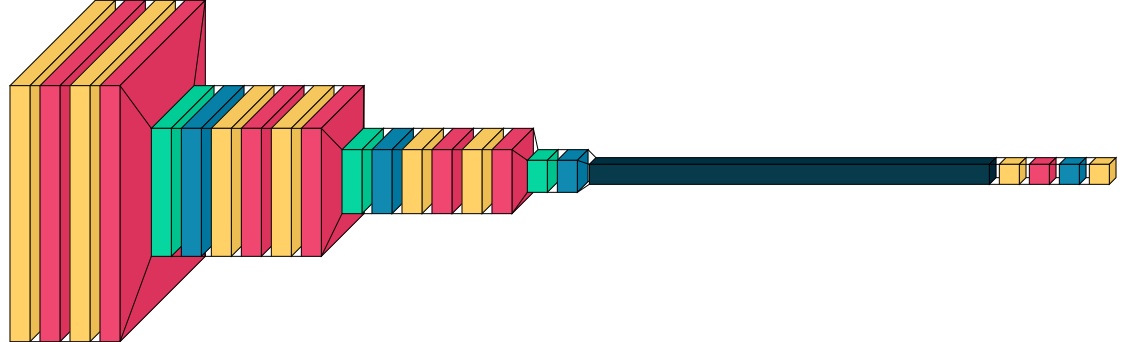

In [ ]:
import visualkeras
visualkeras.layered_view(SCAN)

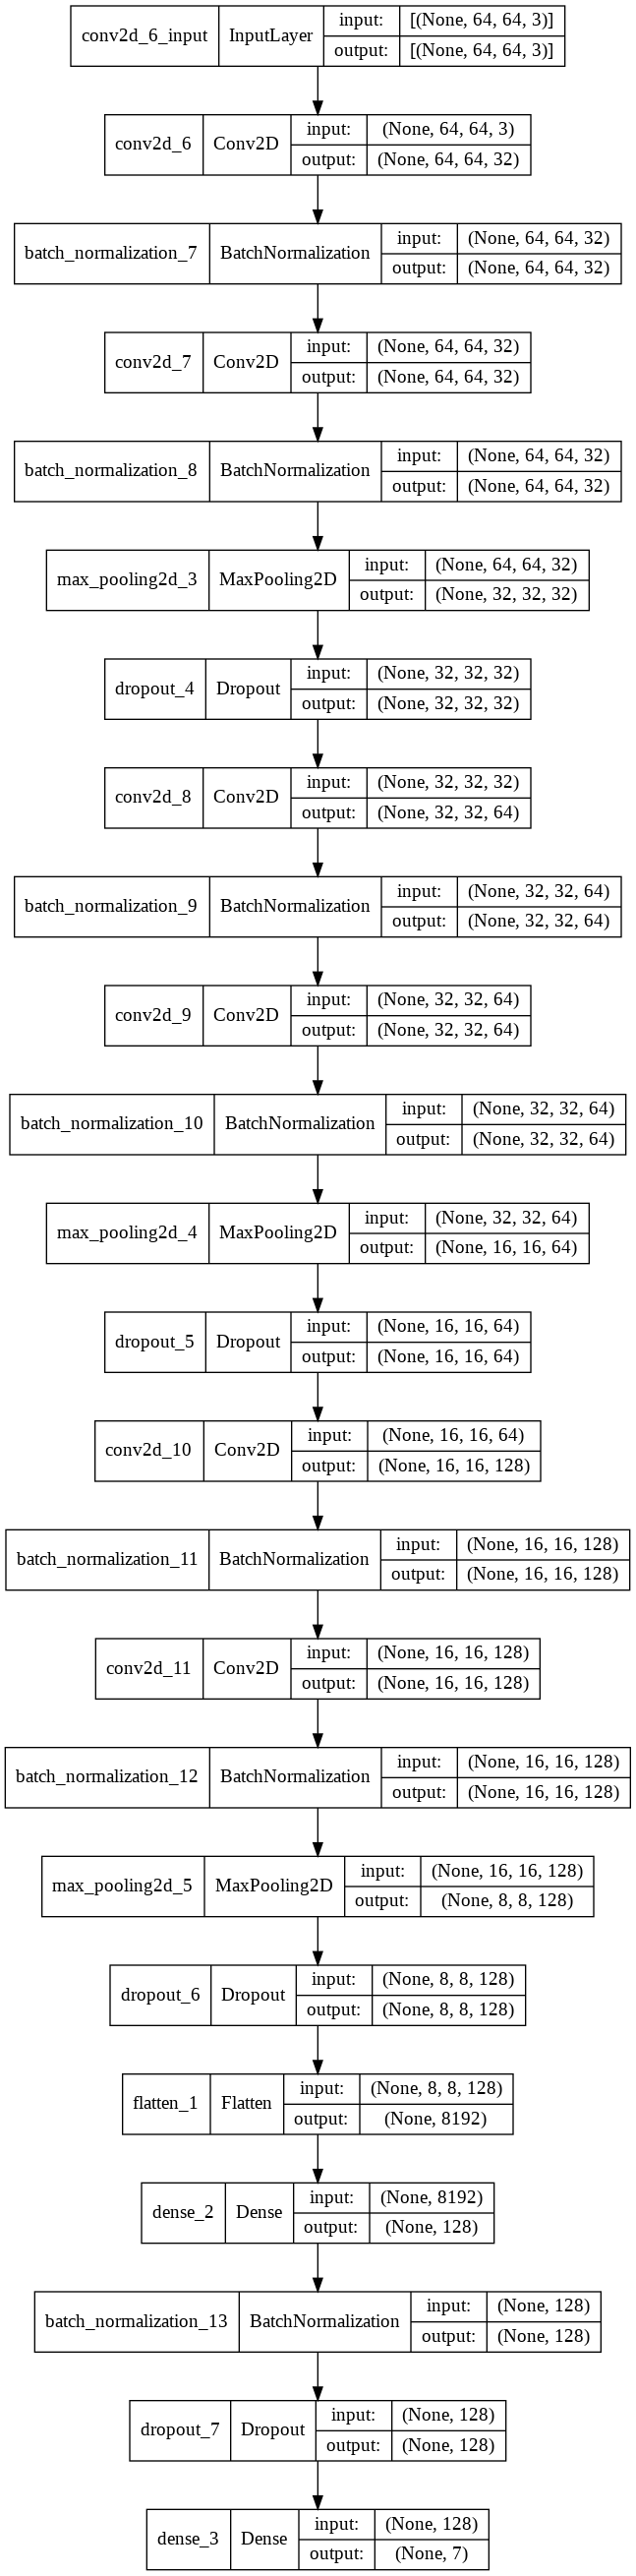

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(SCAN, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Train

In [ ]:
# create weights for each class
from sklearn.utils import compute_class_weight
import numpy as np
class_weights = dict(enumerate(compute_class_weight('balanced',
                                      classes=np.unique(y),
                                      y=y)))

# # create weights for each class
# from sklearn.utils import compute_class_weight
# import numpy as np
# class_weights = dict(enumerate(compute_class_weight('balanced',
#                                       classes=np.unique(train_generator.labels),
#                                       y=train_generator.labels)))

In [ ]:
#nv 4
#mel 6
#bkl 2
#bcc 1
#akiec 0
#vasc 5
#df 3

class_weights[0] = class_weights[0]*3.75
class_weights[1] = class_weights[1]*5.4
class_weights[6] = class_weights[6]*11.7

In [ ]:
class_weights

{0: 16.407273918741808,
 1: 15.030850472484714,
 2: 1.301832835044846,
 3: 12.440993788819876,
 4: 0.21338020666879728,
 5: 10.075452716297788,
 6: 15.039853677319984}

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)

In [ ]:
y_val = to_categorical(y_val)

In [ ]:
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_test)

In [ ]:
# function to load images from generator into a variable
def generate_data_from_datagen(generator, batch_size): 
 
  total_images = generator.n
  steps = total_images//batch_size 
  #iterations to cover all data, so if batch is 5, it will take total_images/5  iteration 
  x , y = [] , []
  for i in range(steps):
      a , b = generator.next()
      x.extend(a) 
      y.extend(b)
      
  return np.array(x), np.array(y)

In [ ]:
X_train, y_train = generate_data_from_datagen(train_generator, batch_size)
X_val, y_val = generate_data_from_datagen(val_generator, batch_size)

In [ ]:
# Hyperparameters
lr = 0.001
mom = 0.9 
ep = 30

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD
# Define the optimizer
opt = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# opt = SGD(learning_rate=lr, momentum=mom)

In [ ]:
from keras.callbacks import ReduceLROnPlateau
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.75, 
                                            min_lr=0.00001)

In [ ]:
# compile and fit the keras model
SCAN.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

step_train = train_generator.n//train_generator.batch_size
step_val = val_generator.n//val_generator.batch_size


history = SCAN.fit(train_generator,
          steps_per_epoch=step_train,
          validation_data=val_generator,
          validation_steps=step_val,
          batch_size=30,
          epochs=ep,
          class_weight=class_weights
          )
#validation_data=(X_val,y_val),
# history = SCAN.fit(train_generator,#X_train,y_train,
#           steps_per_epoch=step_train,
#           validation_data=val_generator,#(X_val,y_val),
#           validation_steps=step_val,
#           epochs=ep,
#           callbacks=[learning_rate_reduction],
#           class_weight=class_weights)


Epoch 1/30
267/267 [==============================] - 22s 76ms/step - loss: 2.9341 - accuracy: 0.4510 - val_loss: 1.5832 - val_accuracy: 0.4677
Epoch 2/30
267/267 [==============================] - 18s 66ms/step - loss: 2.9604 - accuracy: 0.4389 - val_loss: 1.5815 - val_accuracy: 0.4970
Epoch 3/30
267/267 [==============================] - 19s 72ms/step - loss: 2.9076 - accuracy: 0.4463 - val_loss: 1.9899 - val_accuracy: 0.1859
Epoch 4/30
267/267 [==============================] - 19s 70ms/step - loss: 2.8946 - accuracy: 0.4516 - val_loss: 1.5531 - val_accuracy: 0.5101
Epoch 5/30
267/267 [==============================] - 17s 63ms/step - loss: 2.9043 - accuracy: 0.4436 - val_loss: 1.6884 - val_accuracy: 0.5000
Epoch 6/30
267/267 [==============================] - 17s 63ms/step - loss: 2.8436 - accuracy: 0.4495 - val_loss: 1.5878 - val_accuracy: 0.4545
Epoch 7/30
267/267 [==============================] - 17s 65ms/step - loss: 2.8114 - accuracy: 0.4491 - val_loss: 2.1029 - val_accuracy:

In [ ]:
SCAN.save("/content/drive/MyDrive/539 Project/ham10000/SCAN_v19.h5")

In [ ]:
from keras.models import load_model
 
# load model
SCAN = load_model('/content/drive/MyDrive/Colab Notebooks/ham10000/SCAN.h5')
SCAN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 75, 32)       896       
                                                                 
 batch_normalization (BatchN  (None, 100, 75, 32)      128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 75, 32)       9248      
                                                                 
 batch_normalization_1 (Batc  (None, 100, 75, 32)      128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 37, 32)       0         
 )                                                               
                                                        

### Bottleneck test

### Test

In [ ]:
# You can visualize the results with a confusion matrix.
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
def plot_confusion_matrix(y_classified, y_true):
  # Compute confusion matrix
  c_mat = np.zeros((y_test.shape[1],y_test.shape[1]))
  for i in range(len(y_true)):
    c_mat[y_classified[i], y_true[i] ] += 1

  group_counts = ["{0:0.0f}".format(value) for value in c_mat.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in c_mat.flatten()/np.sum(c_mat)]
  labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
  labels = np.asarray(labels).reshape(c_mat.shape[0], c_mat.shape[1])

  plt.figure(figsize=(12,10))
  sn.heatmap(c_mat, annot=labels, fmt='', cmap='rocket_r')
  plt.title("Confusion Matrix")
  plt.ylabel('Output Class')
  plt.xlabel('Target Class')

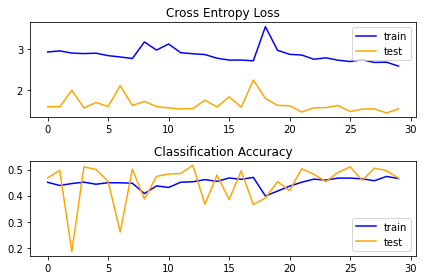

In [ ]:
# plot loss
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.legend()
# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')
plt.legend()
plt.tight_layout()

In [ ]:
import numpy as np


X_test, y_test = generate_data_from_datagen(test_generator, batch_size)

In [ ]:
# Evaluate the trained model using keras built-in function
score = SCAN.evaluate(X_test, y_test, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1]) 

32/32 [==============================] - 1s 13ms/step - loss: 1.5333 - accuracy: 0.4711
Test loss: 1.5332854986190796
Test accuracy: 0.4710578918457031


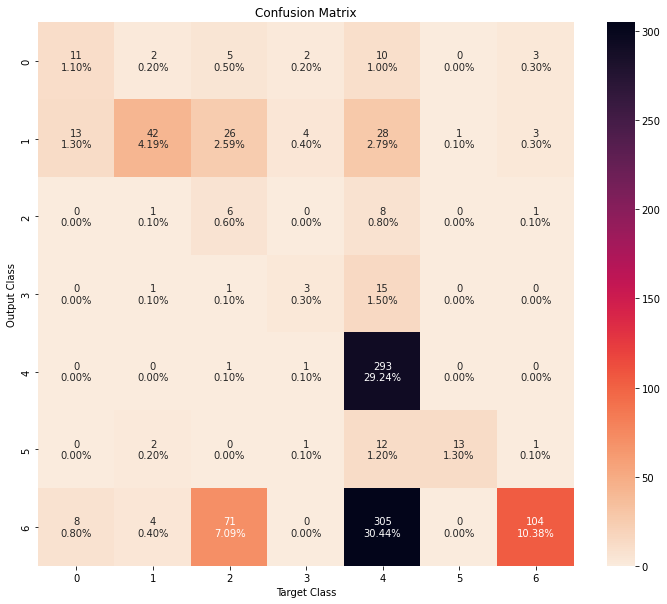

In [ ]:
y_classified = np.argmax(SCAN.predict(X_test), axis=1)
y_true =  np.argmax(y_test, axis=1)
# plot confusion matrix
plot_confusion_matrix(y_classified, y_true)

In [ ]:
from sklearn.metrics import recall_score
recall_score(y_classified, y_true, average='macro', zero_division=0)

0.4100265724544067

In [ ]:
# Plot ROC curves for each class (some variables need changing)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc

y_classified = SCAN.predict(X_test)


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_classified[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_classified.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])




# fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))
# for i, c_all in enumerate(train_generator.classes):
#     tpr, fpr, thresh = roc_curve(y_true=t_y_ohe[:, i], y_score=t_yp[:, i])
#     auc_roc = roc_auc_score(y_true=t_y_ohe[:, i], y_score=t_yp[:, i])
#     ax1.plot(tpr, fpr, '.-', label='{} (AUC:{:2.1%})'.format(c_all, auc_roc), lw=2)
# ax1.legend()

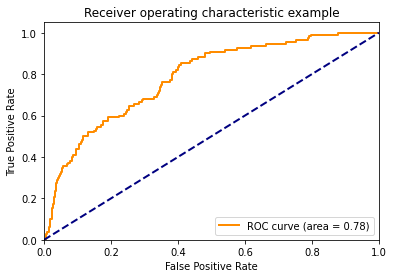

In [ ]:
plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


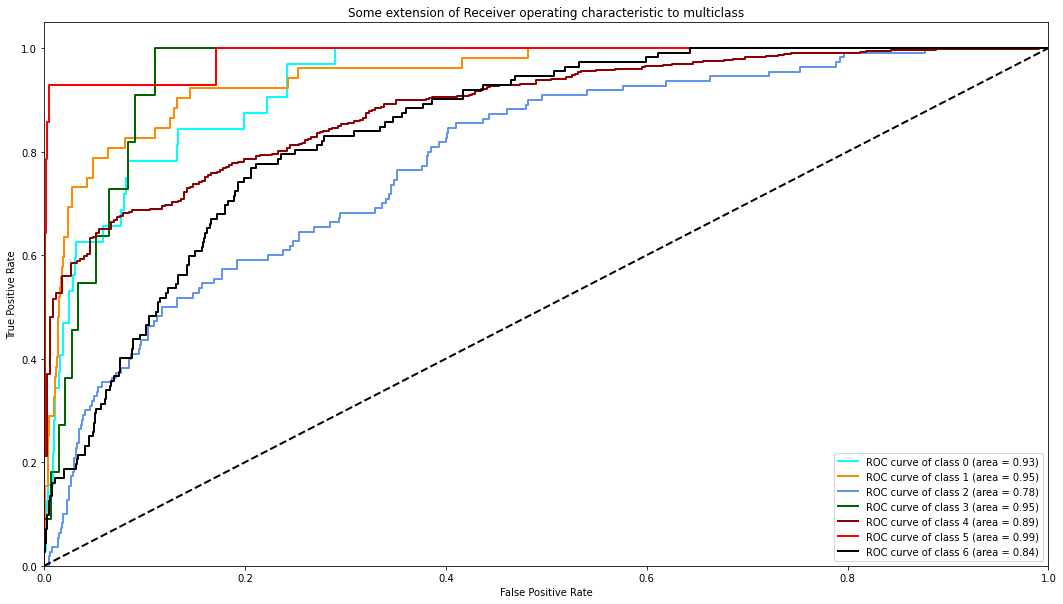

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

# First aggregate all false positive rates
n_classes = 7
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(18,10))
# plt.plot(
#     fpr["micro"],
#     tpr["micro"],
#     label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
#     color="deeppink",
#     linestyle=":",
#     linewidth=4,
# )

# plt.plot(
#     fpr["macro"],
#     tpr["macro"],
#     label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
#     color="navy",
#     linestyle=":",
#     linewidth=4,
# )

colors = cycle(["aqua", "darkorange", "cornflowerblue","darkgreen","darkred","red","black"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()